In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import operator

In [2]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")
#print(routes_df.keys())
#print(airports_df.keys())

In [3]:
airports_by_iata_df = airports_df.groupby("IATA")

In [4]:
airports_by_longtitude_df = airports_df.groupby("Longitude")
airports_by_lattitude_df = airports_df.groupby("Latitude")

In [5]:
airport_nodes = list(airports_by_iata_df.groups)

In [6]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

In [7]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)
airport_routes_digraph.add_edges_from([(airport_src[i],airport_dest[i]) for i in range(len(airport_src))]);

## Cleaning up, making the graph weakly connected

In [8]:
airport_nodes_weakly = [n for n in airport_nodes if n in airport_src or n in airport_dest]

airport_routes_digraph_weakly = nx.MultiDiGraph()

airport_routes_digraph_weakly.add_nodes_from(airport_nodes_weakly)
airport_routes_digraph_weakly.add_edges_from([(airport_src[i],airport_dest[i]) for i in range(len(airport_src))]);

# Average shortest path 

In [9]:
airport_undirected = nx.to_undirected(airport_routes_digraph_weakly)
nx.is_connected(airport_undirected)

subgraphs = nx.connected_component_subgraphs(airport_undirected)

print "Edges in graph: " + str(airport_undirected.number_of_edges())
print "Nodes in graph: " +  str(airport_undirected.number_of_nodes())
big_subgraph = max(subgraphs,key=lambda x: x.number_of_edges())

print
print "Edges in subgraph: " + str(big_subgraph.number_of_edges())
print "Nodes in subgraph: " +  str(big_subgraph.number_of_nodes())

Edges in graph: 67664
Nodes in graph: 3425

Edges in subgraph: 34789
Nodes in subgraph: 3397


In [10]:

print "The average shortest path through out our networg is: " + str(nx.average_shortest_path_length(big_subgraph))

The average shortest path through out our networg is: 4.1032411679


# Longest Shortest Path

In [11]:
shortest_path_lengths = sorted([(k, max(zip(v.values(), v.keys()))) for k,v in tqdm(nx.shortest_path_length(big_subgraph))],key=lambda x: x[1][0],reverse=True)[:10]

### The shortest paths

In [12]:
paths = []
for item in shortest_path_lengths:
    paths.append(nx.shortest_path(big_subgraph,source=item[0],target=item[1][1]))

In [13]:
print paths[8]
for p in paths[8]:
    print airports_by_iata_df.get_group(p).iloc[0]['Name']

['PTJ', 'MEB', 'FLS', 'LST', 'BNE', 'TPE', 'YYZ', 'YTS', 'YMO', 'YFA', 'ZKE', 'YAT', 'YPO']
Portland Airport
Melbourne Essendon Airport
Flinders Island Airport
Launceston Airport
Brisbane International Airport
Taiwan Taoyuan International Airport
Lester B. Pearson International Airport
Timmins/Victor M. Power
Moosonee Airport
Fort Albany Airport
Kashechewan Airport
Attawapiskat Airport
Peawanuck Airport


In [14]:
edgeys = []
for i in range(0,len(paths[8])-1):
    edgeys.append((paths[8][i],paths[8][i+1]))

In [15]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

positions = {}

for node in airport_routes_digraph.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    
    
options = {
    'width': 0.2,
    'alpha': 0.9,
    'node_size': 50,
    'with_labels': False
}

/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


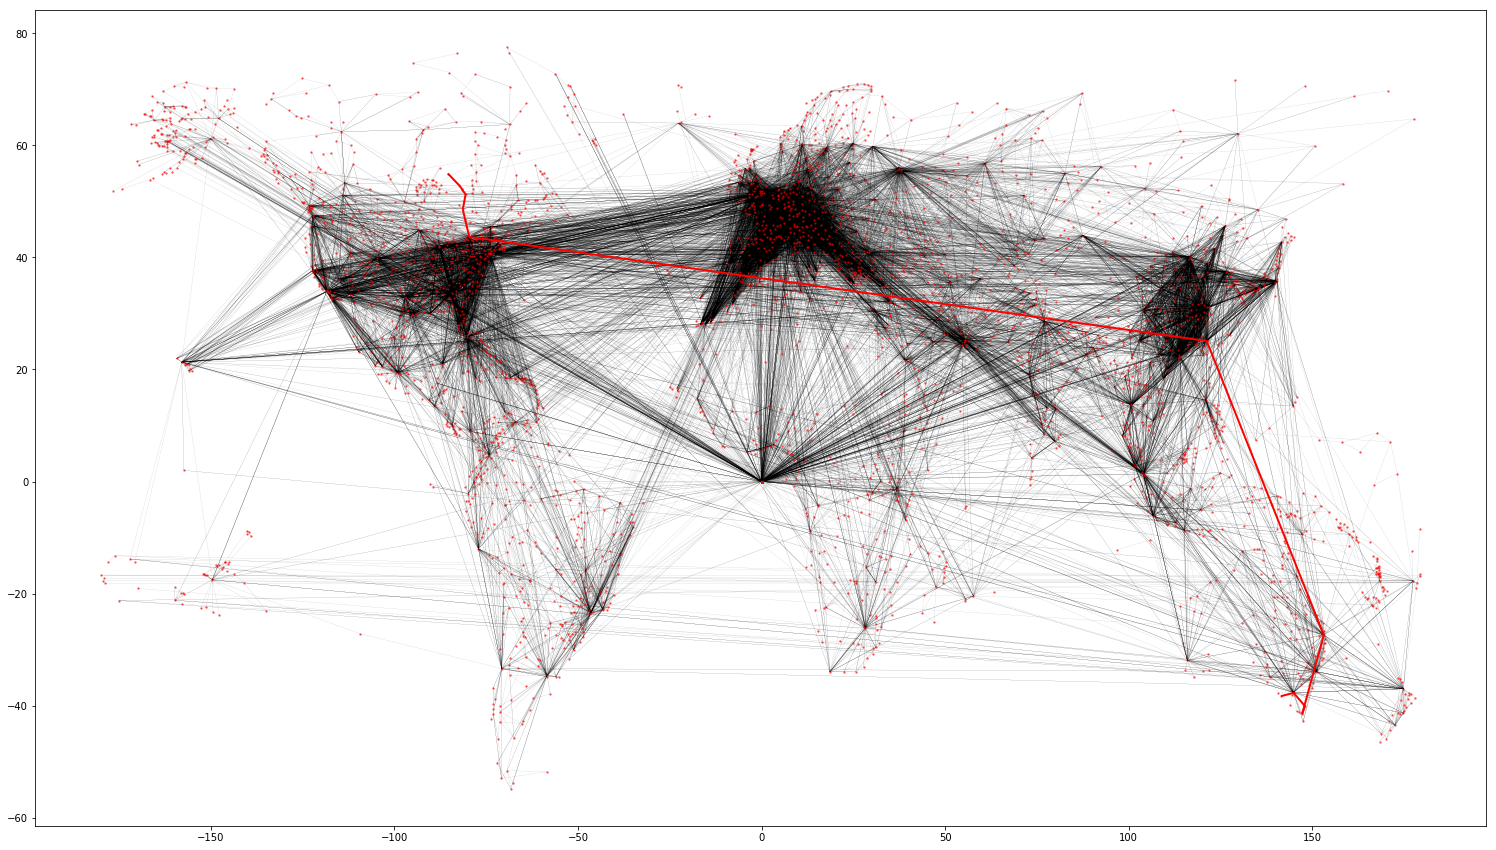

In [16]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_undirected, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))
nx.draw_networkx_edges(airport_undirected,positions, edgelist=edgeys, width = 2, alpha = 1, edge_color='r')
fig.show()

In [17]:
fig.savefig("longest_shortest_path.png")

In [18]:
d = dict(nx.degree(big_subgraph))

## Node size in terms of node degree

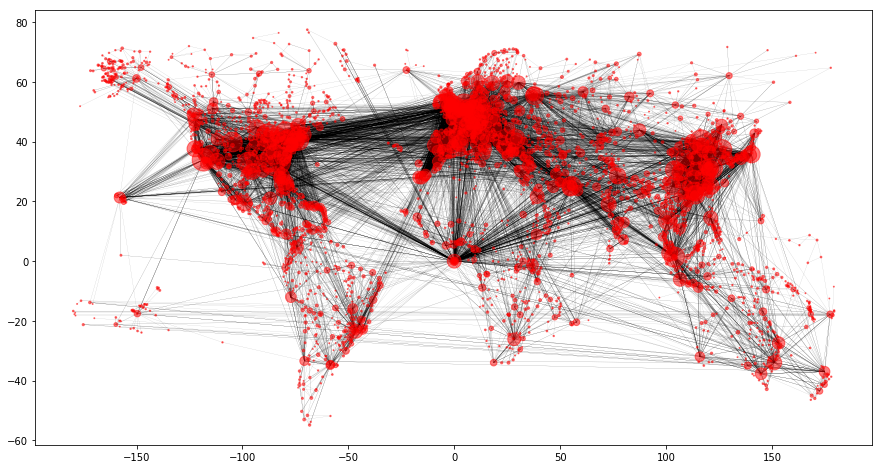

In [19]:
plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 1 for v in d.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.show()

## Node size in terms of betweenness centrality

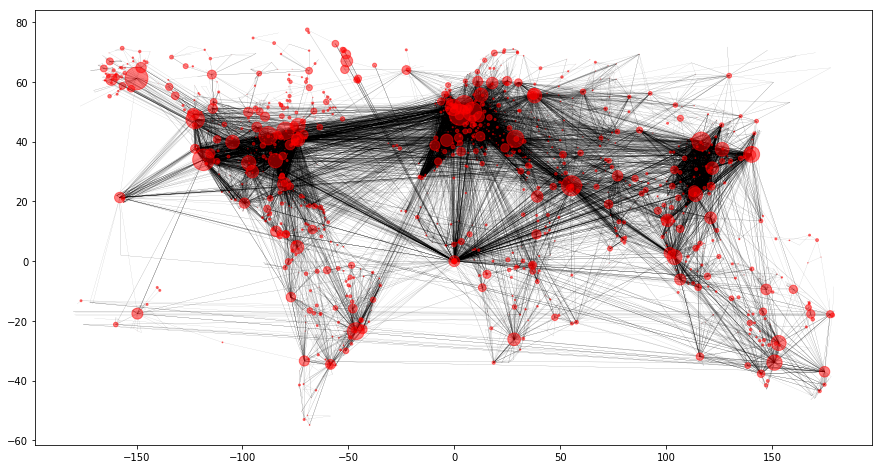

In [20]:
bc = nx.betweenness_centrality(big_subgraph)
plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 7000 for v in bc.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.show()

## Node size in terms of eigenvector centrality

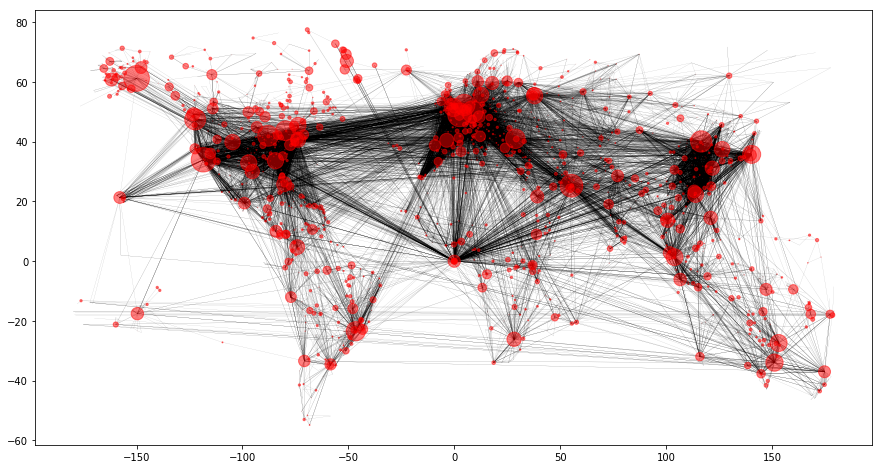

In [21]:
ec = nx.eigenvector_centrality(nx.Graph(big_subgraph))
plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 9000 for v in bc.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.show()

## Airports with the most connections (highest degree)

In [22]:
top_airports_degree = sorted(d.iteritems(),key = lambda (k,v):(v,k),reverse=True)[:10]
for ai,de in top_airports_degree:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], de)

('Hartsfield Jackson Atlanta International Airport', 935)
("Chicago O'Hare International Airport", 559)
('Beijing Capital International Airport', 538)
('Charles de Gaulle International Airport', 537)
('London Heathrow Airport', 533)
('Los Angeles International Airport', 509)
('Frankfurt am Main International Airport', 506)
('Amsterdam Airport Schiphol', 481)
('Dallas Fort Worth International Airport', 476)
('John F Kennedy International Airport', 461)


## Airports with the highest betweeness centrality

In [23]:
top_airports_betweenness = sorted(bc.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, be in top_airports_betweenness:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], be)

('Ted Stevens Anchorage International Airport', 0.07368305077781415)
('Los Angeles International Airport', 0.06628762656925467)
('Charles de Gaulle International Airport', 0.06296156906124929)
('Dubai International Airport', 0.05742339794895801)
('Frankfurt am Main International Airport', 0.051931709656700464)
('Beijing Capital International Airport', 0.050390147930148566)
('Amsterdam Airport Schiphol', 0.050078253889594526)
('Seattle Tacoma International Airport', 0.04890431546361689)
("Chicago O'Hare International Airport", 0.04873371923846339)
('Lester B. Pearson International Airport', 0.04335712632575033)


## Airports with the highest eigenvector centralities

In [24]:
top_airports_eigenvector = sorted(ec.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, ee in top_airports_eigenvector:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], ee)

('Amsterdam Airport Schiphol', 0.16785098412044241)
('Frankfurt am Main International Airport', 0.16639184654015735)
('Charles de Gaulle International Airport', 0.15945060970185462)
('Munich International Airport', 0.14851297815057107)
('Leonardo da Vinci\x96Fiumicino Airport', 0.1363304994655765)
('London Heathrow Airport', 0.13613831088577127)
('Atat\xfcrk International Airport', 0.12932930994026737)
('Barcelona International Airport', 0.1281089923287042)
('Z\xfcrich Airport', 0.1259939800042866)
('Adolfo Su\xe1rez Madrid\x96Barajas Airport', 0.12295294344636262)
